In [290]:
import pandas as pd
import numpy as np
from scipy import stats as scs
import statsmodels.api as sms
import matplotlib.pyplot as plt

In [291]:
folder_path = '/Users/jonasmacbook/Development/Quantitative_Trading/pairs_trading/source_data'
filename1 = 'GLD.xls'
filename2 = 'GDX.xls'
price_data1 = pd.read_excel(folder_path+'/' + filename1)
price_data2 = pd.read_excel(folder_path+'/' + filename2)

In [292]:
IN_SCOPE_COLUMNS = ['Date', 'Open', 'High','Low','Close', 'Adj Close']

# Read in dataframe GLD.XLS

In [293]:
#drop all columns that we dont need
for col in price_data1.columns:
    if col not in IN_SCOPE_COLUMNS:
        price_data1.drop([col], inplace=True, axis=1)
            
if 'Close' in price_data1.columns and 'Adj Close' in price_data1.columns:
    price_data1.drop(['Close'], inplace=True, axis=1) #prefer Adjusted close

#change names to columns 
price_data1.columns = ['Date', 'Opening price', 'High price', 'Low price', 'Closing price']

#Remove '-' from Date string -> YYYYMMDD
if price_data1['Date'].dtype != np.str:
    price_data1['Date'] = price_data1['Date'].astype(str)
    price_data1['Date'] = price_data1['Date'].str.replace('\D','').astype(int)
else:
    price_data1['Date'] = price_data1['Date'].str.replace('\D','').astype(int)
            
#sort rows based on Date in Ascending order. 
price_data1 = price_data1.sort_values(ascending=True, by=['Date']) 

#if column(closing prices) is of type np.str, this is likely because the decimal point separate is a ',' rather than '.'  
if price_data1['Closing price'].dtype != np.number:
    price_data1['Closing price'] = price_data1['Closing price'].str.replace(',','.').astype(float)

In [294]:
#drop all columns that we dont need
for col in price_data2.columns:
    if col not in IN_SCOPE_COLUMNS:
        price_data2.drop([col], inplace=True, axis=1)
            
if 'Close' in price_data2.columns and 'Adj Close' in price_data2.columns:
    price_data2.drop(['Close'], inplace=True, axis=1) #prefer Adjusted close

#change names to columns 
price_data2.columns = ['Date', 'Opening price', 'High price', 'Low price', 'Closing price']

#Remove '-' from Date string -> YYYYMMDD
if price_data2['Date'].dtype != np.str:
    price_data2['Date'] = price_data2['Date'].astype(str)
    price_data2['Date'] = price_data2['Date'].str.replace('\D','').astype(int)
else:
    price_data2['Date'] = price_data2['Date'].str.replace('\D','').astype(int)
            
#sort rows based on Date in Ascending order. 
price_data2 = price_data2.sort_values(ascending=True, by=['Date']) 

#if column(closing prices) is of type np.str, this is likely because the decimal point separate is a ',' rather than '.'  
if price_data2['Closing price'].dtype != np.number:
    price_data2['Closing price'] = price_data2['Closing price'].str.replace(',','.').astype(float)

In [295]:
gdx_df = price_data2
gld_df = price_data1

## Pairs trading specific

In [296]:
com_df = pd.merge(gld_df, gdx_df, on='Date', suffixes=('_GLD', '_GDX'))
com_df.head(5)

,Date,Opening price_GLD,High price_GLD,Low price_GLD,Closing price_GLD,Opening price_GDX,High price_GDX,Low price_GDX,Closing price_GDX
0,20060523,65.99,67.16,65.91,66.38,37.75,39.22,37.75,37.85
1,20060524,64.83,65.16,63.22,64.06,37.13,37.57,35.87,36.41
2,20060525,64.12,64.76,63.76,64.70,37.18,38.32,36.98,38.21
3,20060526,65.01,65.10,63.75,65.10,38.74,38.74,37.77,38.44
4,20060530,65.20,66.24,65.00,65.11,39.50,39.72,38.11,38.06


In [297]:
trainset = np.array(range(252)) #creates array indices 0 to 251
testset = np.array(range(trainset[-1] + 1, len(tday_intersect)))

## Hedge ratio

In [298]:
com_df.set_index('Date', inplace=True)

In [299]:
model = sms.OLS(com_df.loc[:, 'Closing price_GLD'].iloc[trainset], com_df.loc[:, 'Closing price_GDX'].iloc[trainset])
result = model.fit()

In [300]:
hedgeratio = result.params
hedgeratio[0]

1.6310089532247043

In [301]:
spread = com_df.loc[:,'Closing price_GLD'] - hedgeratio[0] * com_df.loc[:,'Closing price_GDX']

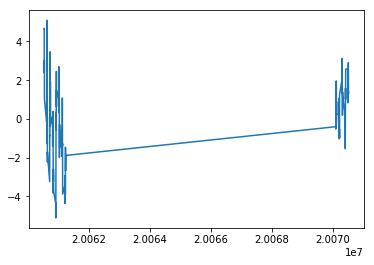

In [302]:
plt.plot(spread.iloc[trainset])

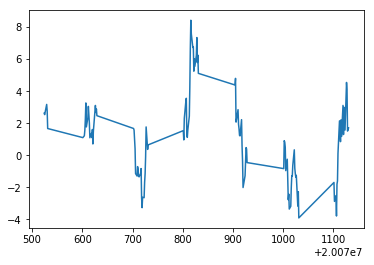

In [303]:
plt.plot(spread.iloc[testset])

In [304]:
spreadMean = np.mean(spread.iloc[trainset])

spreadStd = np.std(spread.iloc[trainset])

zscore = (spread - spreadMean) / spreadStd

com_df['zscore'] = zscore

print("spreadMean: {0}".format(spreadMean))
print("spreadStd: {0}".format(spreadStd))


spreadMean: 0.05219623850035999
spreadStd: 1.944860873496509


## Take buy/sell positions

In [305]:
com_df['GLD_positions'] = np.nan
com_df['GDX_positions'] = np.nan

In [306]:
com_df.loc[com_df['zscore']<=-2, ['GLD_positions', 'GDX_positions']] = [1, -1] #Buy long
com_df.loc[com_df['zscore']>=2, ['GLD_positions', 'GDX_positions']] = [-1, 1] #Buy short
com_df.loc[abs(com_df['zscore'])<=1, ['GLD_positions', 'GDX_positions']] = 0 #Exit position

## fill any missing values

In [307]:
com_df.fillna(method='ffill', inplace=True) #forward fill prices
#com_df.fillna(method='bfill', inplace=True) #forward fill prices

In [308]:
positions = com_df.loc[:,('GLD_positions', 'GDX_positions')]

In [309]:
dailyret = com_df.loc[:, ['Closing price_GLD', 'Closing price_GDX']].pct_change()

In [310]:
PnL = (np.array(positions.shift()) * np.array(dailyret)).sum(axis=1) #shift one period because the first row in dailyret is NaN

In [311]:
SharpeTrainset = np.sqrt(252) * np.mean(PnL[trainset[1:]])/np.std(PnL[trainset[1:]])

In [312]:
SharpeTrainset

2.3324949367127323

In [313]:
np.mean(PnL[trainset[1:]])

0.0007873123689857315

In [314]:
SharpeTestset = np.sqrt(252) * np.mean(PnL[testset])/np.std(PnL[testset])

In [315]:
SharpeTestset

1.5139137120213677

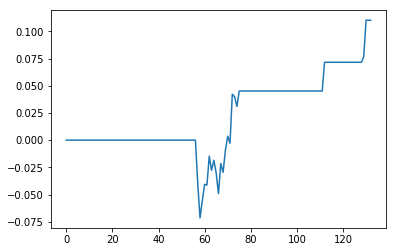

In [316]:
plt.plot(np.cumsum(PnL[testset], axis=0))

In [275]:
positions.to_pickle('example3_6_positions')

In [337]:
arr = np.array(spread.iloc[trainset])

In [338]:
plt.subplot(arr)

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 432x288 with 0 Axes>

In [327]:
m.shape

(4,)